### IMPORT LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
import keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage import io
from skimage.color import rgb2gray

### IMPORTING / VIEWING / PREPROCESSING DATASET 

> `DATA AUGMENTATION`

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [19]:
test_dataset = test_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 1)

Found 1279 images belonging to 4 classes.


In [5]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [6]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|██████████| 5/5 [00:16<00:00,  3.29s/it]


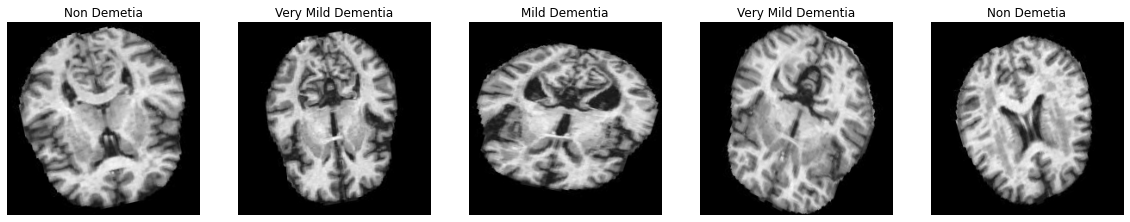

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### MODEL BUILDING

In [8]:
base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

2023-01-07 17:30:50.432858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


   16384/58889256 [..............................] - ETA: 1s

2023-01-07 17:30:50.541675: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 17:30:50.542741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-07 17:30:50.545742: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-07 17:30:50.546072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

58900480/58889256 [==============================] - 0s 0us/step


In [9]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [10]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [11]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [12]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [13]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRICS = [
      tensorflow.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),  
        f1_score,
          ]
model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
# Defining Callbacks


def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [15]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                        callbacks = callback_list,
                        verbose = 1)

2023-01-07 17:31:11.749657: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-07 17:31:16.352125: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


33/33 [==============================] - 96s 2s/step - loss: 1.3980 - Categorical Accuracy: 0.4985 - precision: 0.5197 - recall: 0.4661 - f1_score: 0.5049 - val_loss: 2.0844 - val_Categorical Accuracy: 0.3167 - val_precision: 0.2968 - val_recall: 0.2571 - val_f1_score: 0.2760
Epoch 2/100
33/33 [==============================] - 54s 2s/step - loss: 1.1305 - Categorical Accuracy: 0.5503 - precision: 0.5719 - recall: 0.5046 - f1_score: 0.5350 - val_loss: 1.2572 - val_Categorical Accuracy: 0.4233 - val_precision: 0.4816 - val_recall: 0.2942 - val_f1_score: 0.3652
Epoch 3/100
33/33 [==============================] - 53s 2s/step - loss: 1.0343 - Categorical Accuracy: 0.5693 - precision: 0.6002 - recall: 0.5100 - f1_score: 0.5497 - val_loss: 1.2551 - val_Categorical Accuracy: 0.4418 - val_precision: 0.4775 - val_recall: 0.3314 - val_f1_score: 0.3910
Epoch 4/100
33/33 [==============================] - 53s 2s/step - loss: 0.9672 - Categorical Accuracy: 0.5825 - precision: 0.6179 - recall: 0.52

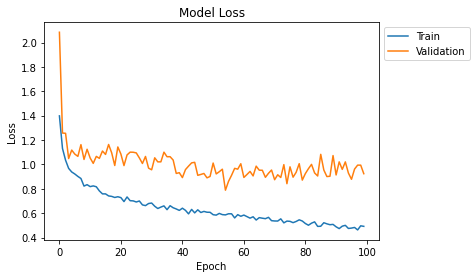

In [16]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [20]:
model.evaluate(test_dataset)


1279/1279 [==============================] - 12s 9ms/step - loss: 0.7888 - Categorical Accuracy: 0.6740 - precision: 0.6836 - recall: 0.6521 - f1_score: 0.6521


[0.7887667417526245,
 0.6739640235900879,
 0.6836065649986267,
 0.6520719528198242,
 0.6520718932151794]

In [21]:

true_classes = test_dataset.classes
class_indices = test_dataset.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = model.predict(test_dataset)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

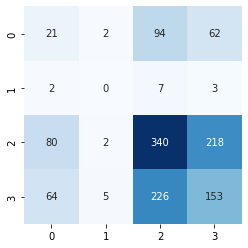

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_dataset.class_indices.keys()

def plot_heatmap(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
    )

plt.figure()
plot_heatmap(true_classes, vgg_pred_classes)    

plt.show()


**Test on second dataset**

In [23]:
test_datagen2  = ImageDataGenerator(rescale = 1./255)
# Test Data 

test_dataset2  = test_datagen.flow_from_directory(directory = '/kaggle/input/alzheimer-mri-dataset/Dataset',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 1)

Found 6400 images belonging to 4 classes.


In [26]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRICS = [
      tensorflow.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),  
        f1_score,
          ]
model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)

In [27]:
# Evaluating Loss and AUC

model.evaluate(test_dataset2)

6400/6400 [==============================] - 60s 9ms/step - loss: 0.5596 - Categorical Accuracy: 0.7850 - precision: 0.7937 - recall: 0.7739 - f1_score: 0.7739


[0.5595749020576477,
 0.7850000262260437,
 0.793749988079071,
 0.7739062309265137,
 0.7739061713218689]